In [1]:
import leaderbot as lb

data = lb.data.load()
model = lb.models.Davidson(data)
model.train()

In [2]:
import numpy as np

max_rank = 20

scores = model.param[:model.n_agents]
rank_ = np.argsort(scores)[::-1]
rank_ = rank_[:max_rank]
scores_ranked = scores[rank_]
agents_ranked = np.array(model.agents)[rank_]

x = data['X']
y = data['Y']

y_sum = y.sum(axis=1, keepdims=True)
y_sum = np.tile(y_sum, (1, y.shape[1]))
p_obs = y / y_sum

# Find which rows of X has (i, j) indices both from rank_
mask = np.isin(x[:, 0], rank_) & np.isin(x[:, 1], rank_)
row_indices = np.where(mask)[0]

# The map j = rank_[i] indicates the rank of i of j.
# Conversely, the inverse map i = revese_rank_[j] indicates the one elemement with rank j is the i-th data
inverse_rank = {value: idx for idx, value in enumerate(rank_)}

In [3]:
n_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=int)
n_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=int)
p_obs_win = np.ma.masked_all((max_rank, max_rank), dtype=float)
p_obs_tie = np.ma.masked_all((max_rank, max_rank), dtype=float)

for row in row_indices:
    i, j = x[row, :]
    rank_i = inverse_rank.get(i, None)
    rank_j = inverse_rank.get(j, None)
    
    n_obs_win[rank_i, rank_j] = y[row, 0]
    n_obs_win[rank_j, rank_i] = y[row, 1]
    n_obs_tie[rank_i, rank_j] = y[row, 2]
    n_obs_tie[rank_j, rank_i] = y[row, 2]

    p_obs_win[rank_i, rank_j] = p_obs[row, 0]
    p_obs_win[rank_j, rank_i] = p_obs[row, 1]
    p_obs_tie[rank_i, rank_j] = p_obs[row, 2]
    p_obs_tie[rank_j, rank_i] = p_obs[row, 2]

In [4]:
p_pred = model.infer(x)
n_pred = p_pred * y_sum

n_pred_win = np.ma.masked_all((max_rank, max_rank), dtype=float)
n_pred_tie = np.ma.masked_all((max_rank, max_rank), dtype=float)

for row in row_indices:
    i, j = x[row, :]
    rank_i = inverse_rank.get(i, None)
    rank_j = inverse_rank.get(j, None)
    
    n_pred_win[rank_i, rank_j] = n_pred[row, 0]
    n_pred_win[rank_j, rank_i] = n_pred[row, 1]
    n_pred_tie[rank_i, rank_j] = n_pred[row, 2]
    n_pred_tie[rank_j, rank_i] = n_pred[row, 2]

In [5]:
x_all = []

# Create mtch indices for all pairs in the rank_
for i in range(max_rank-1):
    for j in range(i+1, max_rank):
        x_all.append([rank_[i], rank_[j]])

x_all = np.array(x_all)

p_pred = model.infer(x_all)
# n_pred = p_pred * y_sum


p_pred_win = np.ma.masked_all((max_rank, max_rank), dtype=float)
p_pred_tie = np.ma.masked_all((max_rank, max_rank), dtype=float)

for row in range(x_all.shape[0]):
    i, j = x_all[row, :]
    rank_i = inverse_rank.get(i, None)
    rank_j = inverse_rank.get(j, None)

    p_pred_win[rank_i, rank_j] = p_pred[row, 0]
    p_pred_win[rank_j, rank_i] = p_pred[row, 1]
    p_pred_tie[rank_i, rank_j] = p_pred[row, 2]
    p_pred_tie[rank_j, rank_i] = p_pred[row, 2]

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import texplot

def _plot_match_matrix(win_table, tie_table, win_range=None, tie_range=None, density=True, horizontal=True, latex=False):

    if density:
        if win_range is None:
            win_vmin = np.ma.min(win_table)
            win_vmax = np.ma.max(win_table)
        else:
            win_vmin, win_vmax = win_range
        if tie_range is None:
            tie_vmin = np.ma.min(tie_table)
            tie_vmax = np.ma.max(tie_table)
        else:
            tie_vmin, tie_vmax = tie_range
    
        # snap = 0.03
        # vmin = round(vmin / snap) * snap
        # vmax = round(vmax / snap) * snap
    
    step_size = 5
    labels = [1] + [i for i in range(step_size, win_table.shape[0] + 1, step_size)]
    
    with texplot.theme(rc={'font.family': 'sans-serif'}, use_latex=latex):

        if horizontal:
            figsize = (9, 4.5)
            nrows = 1
            ncols = 2
        else:
            figsize = (4.5, 9)
            nrows = 2
            ncols = 1
            
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        cmap = 'gist_heat_r'
        
        # Heatmap for wins
        if density:
            im1 = ax[0].imshow(100.0 * win_table, cmap=cmap, vmin=100.0*win_vmin, vmax=100.0*win_vmax)
        else:
            im1 = ax[0].imshow(win_table, cmap=cmap)
            
        ax[0].set_xticks([0] + list(np.arange(step_size-1, win_table.shape[0], step_size)))
        ax[0].set_yticks([0] + list(np.arange(step_size-1, win_table.shape[0], step_size)))
        ax[0].set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
        ax[0].set_yticklabels(labels, fontsize=10)
        ax[0].tick_params(axis='both', length=0)
        ax[0].xaxis.set_ticks_position('top')
        ax[0].xaxis.set_label_position('top')
        ax[0].set_xlabel('Rank')
        ax[0].set_ylabel('Rank')
        ax[0].text(0.5, -0.02, 'Win Matrix', ha='center', va='top', transform=ax[0].transAxes)
        
        divider1 = make_axes_locatable(ax[0])
        cax1 = divider1.append_axes("right", size="5%", pad=0.06)
        cbar1 = fig.colorbar(im1, cax=cax1)

        if density:
            cbar1.ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
        
        # Heatmap for ties
        if density:
            im2 = ax[1].imshow(100.0*tie_table, cmap=cmap, vmin=100.0*tie_vmin, vmax=100.0*tie_vmax)
        else:
            im2 = ax[1].imshow(tie_table, cmap=cmap)
        
        ax[1].set_xticks([0] + list(np.arange(step_size-1, win_table.shape[0], step_size)))
        ax[1].set_yticks([0] + list(np.arange(step_size-1, win_table.shape[0], step_size)))
        ax[1].set_xticklabels(labels, rotation=0, ha="center", fontsize=10)
        ax[1].set_yticklabels(labels, fontsize=10)
        ax[1].tick_params(axis='both', length=0)
        ax[1].xaxis.set_ticks_position('top')
        ax[1].xaxis.set_label_position('top')
        ax[1].set_xlabel('Rank')
        ax[1].set_ylabel('Rank')
        ax[1].text(0.5, -0.02, 'Tie Matrix', ha='center', va='top', transform=ax[1].transAxes)
        
        divider2 = make_axes_locatable(ax[1])
        cax2 = divider2.append_axes("right", size="5%", pad=0.06)
        cbar2 = fig.colorbar(im2, cax=cax2)

        if density:
            cbar2.ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
        
        plt.tight_layout()

        if not horizontal:
            plt.subplots_adjust(hspace=-0.05)
        plt.show()

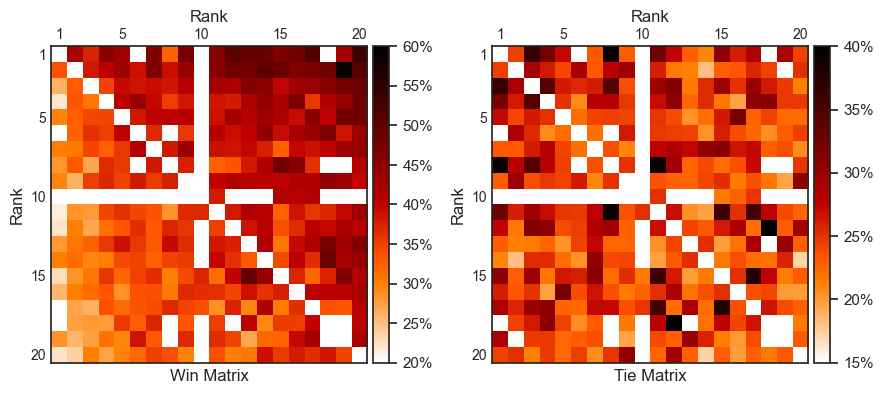

In [7]:
_plot_match_matrix(p_obs_win, p_obs_tie, density=True, win_range=[0.2, 0.6], tie_range=[0.15, 0.4], horizontal=True)

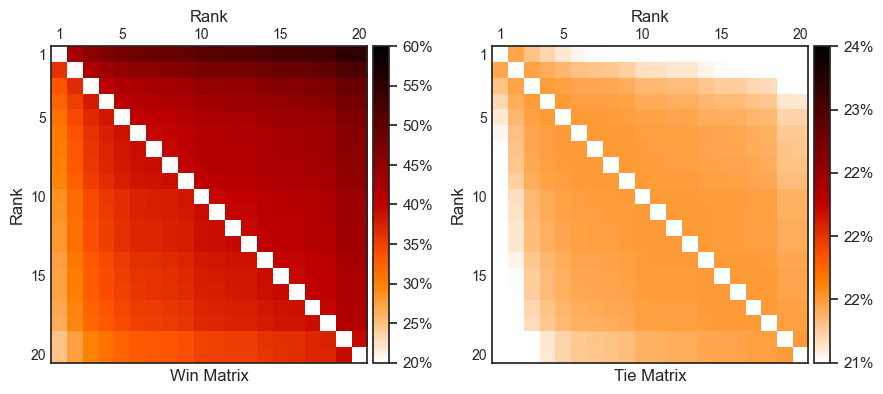

In [8]:
_plot_match_matrix(p_pred_win, p_pred_tie, density=True, win_range=[0.2, 0.6], tie_range=[0.21, 0.235], horizontal=True)

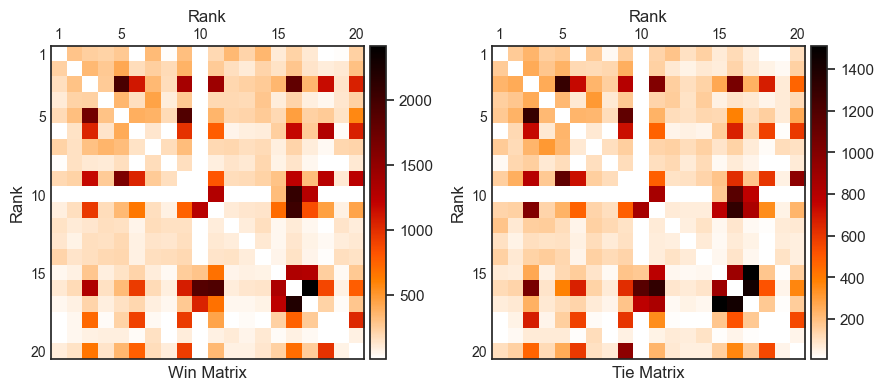

In [9]:
_plot_match_matrix(n_obs_win, n_obs_tie, density=False, horizontal=True)

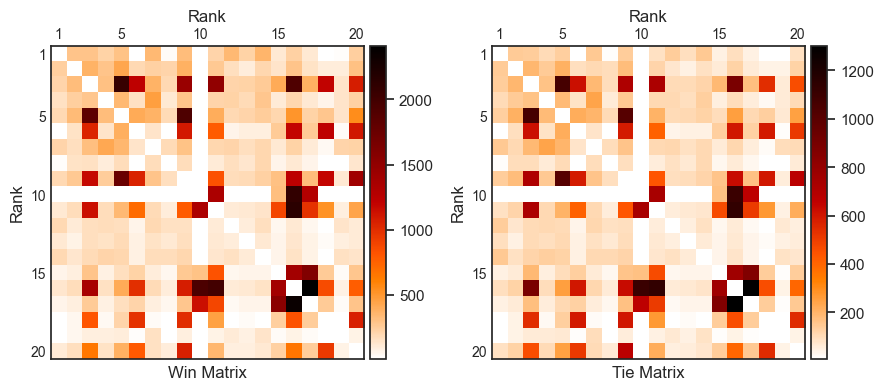

In [10]:
_plot_match_matrix(n_pred_win, n_pred_tie, density=False, horizontal=True)

Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.svg".
Plot saved to "/home/sia/work/github/arenaranking/notebooks/match_matrix.pdf".


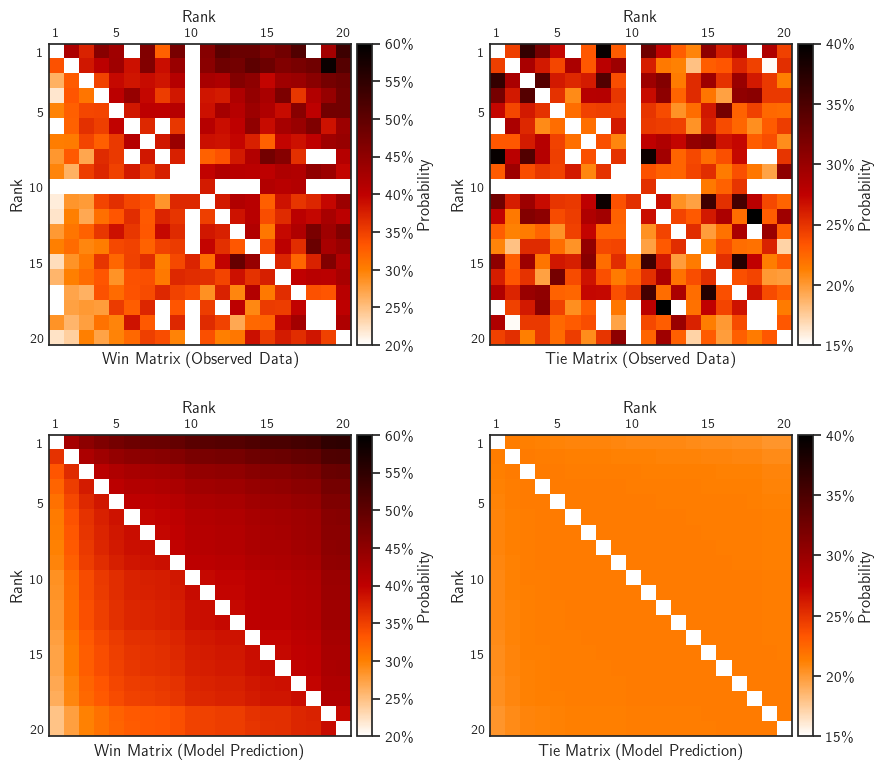

In [3]:
%matplotlib inline
model.match_matrix(max_rank=20, density=True, source='both',
                   latex=True, save=True, horizontal=True,
                   win_range=[0.2, 0.6], tie_range=[0.15, 0.4])